In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.1 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install xgboost

In [3]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import pandas as pd

# Load the human dataset (ensure the correct path)
human_data = pd.read_csv('/kaggle/input/dna-human/human.txt', sep='\t')

# Check the first few rows
human_data.head()


,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [4]:
# Clean: remove any non-ATCG characters
human_data['sequence'] = human_data['sequence'].str.upper().str.replace(r'[^ATCG]', '', regex=True)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to generate k-mers
def generate_kmers(sequence, k=6):
    sequence = sequence.lower()
    if len(sequence) < k:
        return ""  # Return empty string for sequences too short
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    return " ".join(kmers)

# Generate k-mer sequences for all human sequences
kmer_sequences = [generate_kmers(seq, k=6) for seq in human_data['sequence']]
human_data['kmers'] = human_data['sequence'].apply(lambda x: generate_kmers(x, k=6))
human_data

,sequence,class,kmers
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,atgccc tgcccc gcccca ccccaa cccaac ccaact caac...
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,atgaac tgaacg gaacga aacgaa acgaaa cgaaaa gaaa...
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,atgcaa tgcaac gcaaca caacag aacagc acagca cagc...
...,...,...,...
4375,ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...,0,atggaa tggaag ggaaga gaagat aagatt agattt gatt...
4376,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6,atgcag tgcagt gcagtc cagtcc agtcct gtcctt tcct...
4377,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6,atgcag tgcagt gcagtc cagtcc agtcct gtcctt tcct...
4378,ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...,6,atgggg tggggc ggggca gggcac ggcacc gcacct cacc...


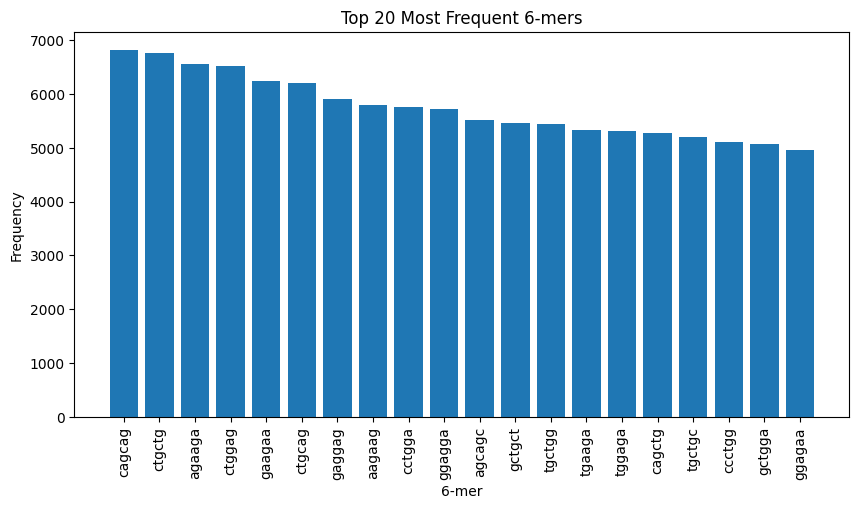

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten all k-mers
all_kmers = " ".join(human_data['kmers']).split()
common_kmers = Counter(all_kmers).most_common(20)

# Plot
kmers, freqs = zip(*common_kmers)
plt.figure(figsize=(10, 5))
plt.bar(kmers, freqs)
plt.xticks(rotation=90)
plt.title("Top 20 Most Frequent 6-mers")
plt.xlabel("6-mer")
plt.ylabel("Frequency")
plt.show()


In [6]:
# Vectorize the k-mer sequences into a feature matrix using CountVectorizer
vectorizer = CountVectorizer(lowercase=False)
X = vectorizer.fit_transform(kmer_sequences).toarray()

# Labels (Human sequences)
y = human_data['class'].values

print(f"Shape of X: {X.shape}, Number of classes: {len(set(y))}")
print (X)

Shape of X: (4380, 4096), Number of classes: 7
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 1 0]
 ...
 [4 2 2 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [10]:

# Vectorize the k-mer sequences into a bag-of-words matrix
vectorizer = CountVectorizer(lowercase=False)
X = vectorizer.fit_transform(kmer_sequences).toarray()
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame from the matrix for easier analysis
X_df = pd.DataFrame(X, columns=feature_names)

# Print shape and unique classes
y = human_data['class'].values
print(f"Shape of X: {X.shape}, Number of classes: {len(set(y))}")

# Show first few rows of the bag-of-words matrix
X_df.head()



Shape of X: (4380, 4469), Number of classes: 7


,aaaaaa,aaaaac,aaaaag,aaaaat,aaaaca,aaaacc,aaaacg,aaaact,aaaaga,aaaagc,...,ttttcg,ttttct,ttttga,ttttgc,ttttgg,ttttgt,ttttta,tttttc,tttttg,tttttt
0,1,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,1,0,1,1,0,0,1,1,...,0,2,3,0,2,0,3,0,1,0
3,0,1,0,0,0,0,0,2,0,1,...,0,1,3,0,2,1,3,0,2,0
4,0,1,1,0,1,1,0,0,1,1,...,0,2,2,0,2,0,3,0,1,0


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.77      0.84       102
           1       0.96      0.75      0.85       106
           2       0.97      0.82      0.89        78
           3       0.90      0.85      0.87       125
           4       0.94      0.89      0.91       149
           5       1.00      0.75      0.85        51
           6       0.76      0.99      0.86       265

    accuracy                           0.87       876
   macro avg       0.92      0.83      0.87       876
weighted avg       0.89      0.87      0.87       876

Confusion Matrix:
 [[ 79   0   0   6   2   0  15]
 [  3  80   0   2   4   0  17]
 [  0   0  64   1   0   0  13]
 [  0   0   0 106   1   0  18]
 [  2   1   0   2 132   0  12]
 [  1   1   2   1   1  38   7]
 [  2   1   0   0   0   0 262]]


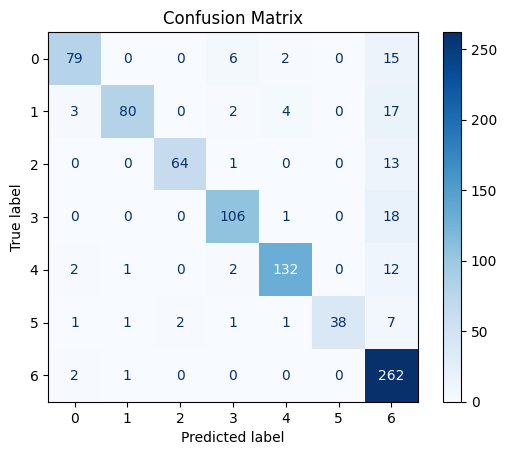

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

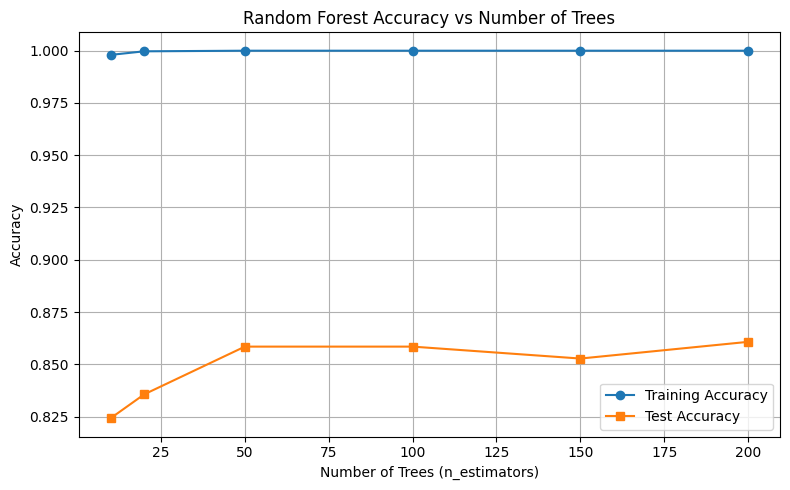

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Track number of estimators and accuracy
estimators = [10, 20, 50, 100, 150, 200]
train_accuracies = []
test_accuracies = []

for n in estimators:
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(estimators, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(estimators, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Number of Trees')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

clf_svm = SVC(kernel='rbf', C=1, probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       102
           1       0.97      0.70      0.81       106
           2       1.00      0.69      0.82        78
           3       0.90      0.74      0.82       125
           4       0.85      0.79      0.82       149
           5       1.00      0.57      0.72        51
           6       0.67      0.99      0.80       265

    accuracy                           0.81       876
   macro avg       0.90      0.75      0.80       876
weighted avg       0.85      0.81      0.81       876



In [39]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       102
           1       0.78      0.75      0.77       106
           2       0.94      0.77      0.85        78
           3       0.88      0.78      0.83       125
           4       0.90      0.70      0.78       149
           5       0.91      0.63      0.74        51
           6       0.72      0.91      0.80       265

    accuracy                           0.79       876
   macro avg       0.83      0.76      0.79       876
weighted avg       0.81      0.79      0.79       876



In [44]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(max_depth=10, random_state=42)
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.47      0.60       102
           1       0.79      0.58      0.67       106
           2       0.88      0.49      0.63        78
           3       0.58      0.31      0.41       125
           4       0.48      0.56      0.52       149
           5       0.75      0.35      0.48        51
           6       0.54      0.89      0.67       265

    accuracy                           0.60       876
   macro avg       0.70      0.52      0.57       876
weighted avg       0.65      0.60      0.58       876



In [43]:
from sklearn.naive_bayes import GaussianNB

clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45       102
           1       0.38      0.36      0.37       106
           2       0.43      0.53      0.47        78
           3       0.44      0.40      0.42       125
           4       0.28      0.70      0.40       149
           5       0.42      0.51      0.46        51
           6       0.76      0.13      0.23       265

    accuracy                           0.38       876
   macro avg       0.46      0.43      0.40       876
weighted avg       0.51      0.38      0.36       876



In [13]:
from xgboost import XGBClassifier
XGBClassifier(tree_method='gpu_hist', gpu_id=0)

clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, max_depth=5)
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       102
           1       0.96      0.85      0.90       106
           2       0.97      0.86      0.91        78
           3       0.88      0.87      0.88       125
           4       0.85      0.86      0.86       149
           5       1.00      0.82      0.90        51
           6       0.82      0.96      0.89       265

    accuracy                           0.88       876
   macro avg       0.92      0.86      0.89       876
weighted avg       0.89      0.88      0.88       876

